In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
df = pd.read_csv("/workspaces/all_in_one/team1proj/StellarDatasetML/data/stellar_eda.csv")

In [3]:
# recode response variable to 0/1/2
#df = df.replace({"class": {"STAR": 0, "GALAXY": 1, "QSO": 2}})

# Trial 2

In [31]:
target = df['class'].copy()
data = df.drop(columns=['class']).copy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

In [ ]:
target.value_counts()

In [17]:
# Z-score
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

fitting a knn model

In [18]:
def accuracy(y_test, y_preds):
  
    total_correct = 0
    for i in range(len(y_test)):
        if int(y_test[i]) == int(y_preds[i]):
            total_correct += 1
    acc = total_correct/len(y_test)
    return acc

In [19]:
# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# create KNN model object
knn = KNeighborsClassifier(n_neighbors=5)

# Train Knn Classifer
knn = knn.fit(X_train,y_train)

In [20]:
# define loss function
loss = 'accuracy'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(knn, X_train_std, y_train, cv=kfold, scoring=loss)


np.round(results, 3)

array([0.907, 0.897, 0.907, 0.908, 0.902])

## Tuning

In [21]:
# create KNN model object
knn = KNeighborsClassifier()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(1, 40, 10)}

# This is the maximum range the we were able to use
# when we used a wider ranger the kernel dies or it keeps workikn for hours

In [22]:
# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_std, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

0.8991767409079893

In [23]:
# Best model's k value
optimal_k = results.best_estimator_.get_params().get('n_neighbors')
optimal_k

1

In [29]:
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best_fit = knn_best.fit(X_train_std, y_train)

predictions = knn_best_fit.predict(X_train_std)
cm = confusion_matrix(y_train, predictions)
cm

array([[33385,     0,     0],
       [    0, 10592,     0],
       [    0,     0, 12022]])

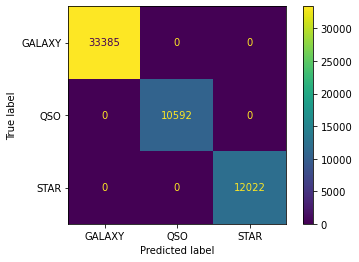

In [30]:
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=knn_best_fit.classes_
  )
  
disp.plot()

In [27]:

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [28]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9105833333333333


In [26]:
print(metrics.classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

      GALAXY       0.90      0.96      0.93     14171
         QSO       0.96      0.88      0.92      4577
        STAR       0.91      0.79      0.85      5252

    accuracy                           0.91     24000
   macro avg       0.92      0.88      0.90     24000
weighted avg       0.91      0.91      0.91     24000

